# Upload data

In [1]:
# Read and show images
from matplotlib import pyplot as plt
import numpy as np
import cv2

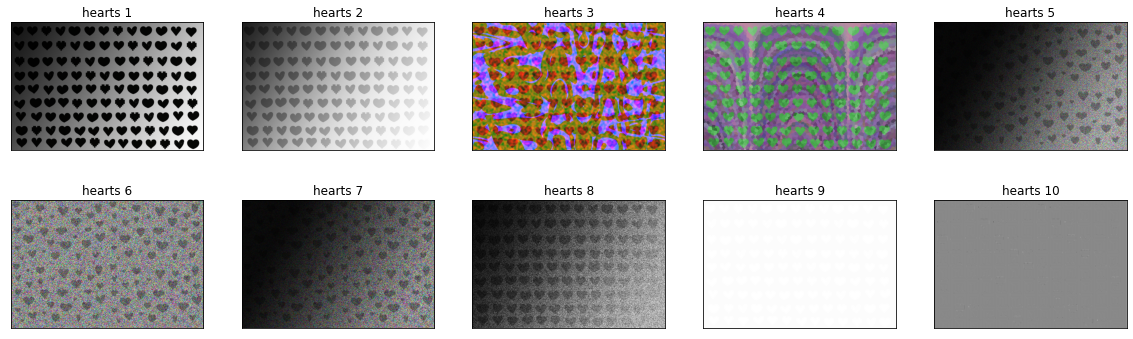

In [2]:
fig, axs = plt.subplots(2, 5, figsize=(20, 6))
imgs = []
for i in range(10):
    img = cv2.imread('data\hearts ' + str(i + 1) + '.png')
    imgs.append(img)
    ax = axs[i // 5, i % 5]
    ax.imshow(img)
    ax.set_title('hearts ' + str(i + 1))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

# Utilities

In [3]:
# Parameters selection utility
def param_selection(image, args_dict, func):
    def nothing(x):
        pass
    # Create a window
    cv2.namedWindow('image')
    args = args_dict.keys()
    # Initialize values
    vals = np.zeros(len(args), dtype='int')
    pVals = np.zeros(len(args), dtype='int')
    for arg in args:
        val = args_dict[arg]
        cv2.createTrackbar(arg, 'image', val[0], val[1], nothing)
    for arg in args:
        val = args_dict[arg]
        cv2.setTrackbarPos(arg, 'image', val[2])

    # Get current positions of all trackbars
        for i, arg in enumerate(args):
            vals[i] = cv2.getTrackbarPos(arg, 'image')
    result = func(image, vals) # Apply changes

    while(1):
        # Get current positions of all trackbars
        for i, arg in enumerate(args):
            vals[i] = cv2.getTrackbarPos(arg, 'image')

        if np.any(np.not_equal(vals, pVals)):
            result = func(image, vals) # Apply changes
            s = ""
            for i, arg in enumerate(args):
                s = s + arg + " = " + str(vals[i]) + " "
            print(s)
            for i in range(len(args)):
                pVals[i] = vals[i]

        # Display result image
        cv2.imshow('image', result)
        if cv2.waitKey(10) & 0xFF == ord('q'):
            break
    cv2.destroyWindow("image")
    cv2.destroyAllWindows()
    
# Collect images during changes to show them with or without histogram
def plot_steps(imgs, names, cols = 3, with_hist = False):
    n = len(imgs)
    rows = int(np.ceil(n / cols))
    k = 2 if with_hist else 1
    fig, axs = plt.subplots(k * rows, cols, figsize=(24, 6 * k * rows))
    for ax in axs.ravel(): # remove axis from all canvas
        ax.axis("off")
    for i, img in enumerate(imgs):
        if with_hist:
            ax = axs[k * (i // cols) + 1, i % cols]
            #print(image.ndim)
            #img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            ax.hist(img.ravel())
        ax = axs[k * (i // cols), i % cols]
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        ax.imshow(img)
        ax.set_title(names[i])
        
def plot_result(original, result):
    fig, axs = plt.subplots(1, 2, figsize=(20, 6))
    ax = axs[0]
    ax.imshow(original)
    ax.set_title('Original')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax = axs[1]
    ax.imshow(result, cmap='gray', label='Result')
    ax.set_title('Result')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
        
def plot_histogram(img):
    hist = cv2.calcHist([img],[0],None,[256],[0,256])
    plt.plot(hist)
    plt.xlim([0,256])
    
# Delete small white pixels
def delete_small_artifacts(img):
    kernel = np.ones((4,4),np.uint8)
    img = cv2.erode(img,kernel,iterations = 2)
    img = cv2.dilate(img,kernel,iterations = 2)
    return img

# Show result in seperate window
def show_result(img):
    cv2.imshow('image',img)
    cv2.waitKey(0)
    cv2.destroyAllWindows()
    
# Choose only contours that big enough
def filter_contours(contours, upper_area_thresh = 100):
    # Find contours with area more than area_thresh
    contours = np.array(contours, dtype='object')
    f = np.vectorize(cv2.contourArea)
    areas = f(contours)
    areas = np.where(areas > upper_area_thresh)
    contours = contours[areas]
    return contours
    
def fill_contours(img, upper_area_thresh = 100, color = (0, 0, 0), external = False, clear_background = False, show_border = False):
    mode = cv2.RETR_EXTERNAL if external else cv2.RETR_TREE
    contours, hierarchy  = cv2.findContours(img, mode, cv2.CHAIN_APPROX_SIMPLE)
    contours = sorted(contours, key=cv2.contourArea, reverse=True)[1:]
    contours = filter_contours(contours, upper_area_thresh)
    if clear_background:
        img = np.zeros([img.shape[0], img.shape[1]],dtype=np.uint8)
        img =255 - img
    if show_border:
        img = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
        cv2.drawContours(img, contours, -1, (0, 255, 255), 5)
    for cnt in contours:
        cv2.fillPoly(img, pts=[cnt], color=color)
    print('Count of objects', len(contours))
    return img
    
def draw_border(img, thickness = 5, mode = 0):
    # mode = 0 - top line, 1 - right, 2 - bottom, 3 - left
    color = (255, 255, 255)
    if mode == 0:
        cv2.line(img,(0,0),(img.shape[1],0),color,thickness=thickness)
    if mode == 1:
        cv2.line(img,(img.shape[1],0),(img.shape[1],img.shape[0]),color,thickness=thickness)
    if mode == 2:
        cv2.line(img,(0,img.shape[0]),(img.shape[1],img.shape[0]),color,thickness=thickness)
    if mode == 3:
        cv2.line(img,(0,0),(0,img.shape[0]),color,thickness)
    return img

# Analyze pictures

In [4]:
show_result_flag = True

<class 'numpy.ndarray'>
(851, 1280, 3)


array([[[  7,   7,   7],
        [  7,   7,   7],
        [  7,   8,   8],
        ...,
        [114, 115, 117],
        [123, 120, 120],
        [132, 128, 127]],

       [[  6,   7,   7],
        [  7,   7,   6],
        [  7,   8,   7],
        ...,
        [118, 120, 117],
        [ 92,  88,  88],
        [124, 126, 130]],

       [[  7,   7,   7],
        [  7,   7,   8],
        [  7,   7,   7],
        ...,
        [123, 123, 121],
        [ 96,  96,  94],
        [135, 133, 134]],

       ...,

       [[ 12,  12,  13],
        [ 15,  14,  15],
        [ 17,  18,  19],
        ...,
        [142, 143, 141],
        [131, 139, 140],
        [149, 158, 159]],

       [[ 14,  13,  14],
        [ 16,  16,  16],
        [ 19,  19,  20],
        ...,
        [163, 156, 169],
        [154, 159, 154],
        [156, 163, 156]],

       [[ 15,  15,  15],
        [ 18,  17,  18],
        [ 21,  20,  22],
        ...,
        [160, 160, 159],
        [160, 157, 163],
        [160, 155, 161]]

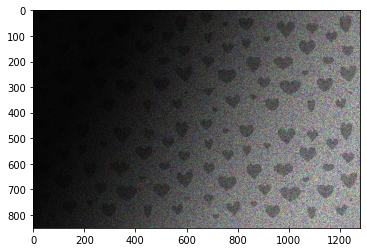

In [11]:
num = 4
img = imgs[num].copy()
print(type(img))
print(img.shape)
img2 = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
plt.imshow(img)
dim = (32, 32)
img = cv2.resize(img, dim, interpolation = cv2.INTER_AREA)
img

## Picture #1, #2
Steps:
 - Since the images have different lightness then we use adaptive threshold
 - After that we have almost perfect image with some small artifacts, so we delete it using morphological operations
 - Then just for checking the result we can find contours and count the amount of objects. There are 9 * 13 = 117 objects

In [ ]:
# Images hearts_1.png and hearts_2.png
def extract(image, name):
    img = image.copy()
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img = cv2.adaptiveThreshold(img,255,cv2.ADAPTIVE_THRESH_MEAN_C,cv2.THRESH_BINARY,95,2)
    # Delete some small artifacts
    img = delete_small_artifacts(img)
    img = draw_border(img, mode = 0)
    plot_result(image, img)
    cv2.imwrite('res\hearts_segmented_'+ name +'.png', img)
    return img
def check_result(img):
    contours, hierarchy  = cv2.findContours(img, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    contours = sorted(contours, key=cv2.contourArea, reverse=True)[1:]
    kernel = np.ones((4,4),np.uint8)
    img = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
    cv2.drawContours(img, contours, -1, (0, 255, 255), 5)
    print('Count of objects', len(contours))
    plt.imshow(img)

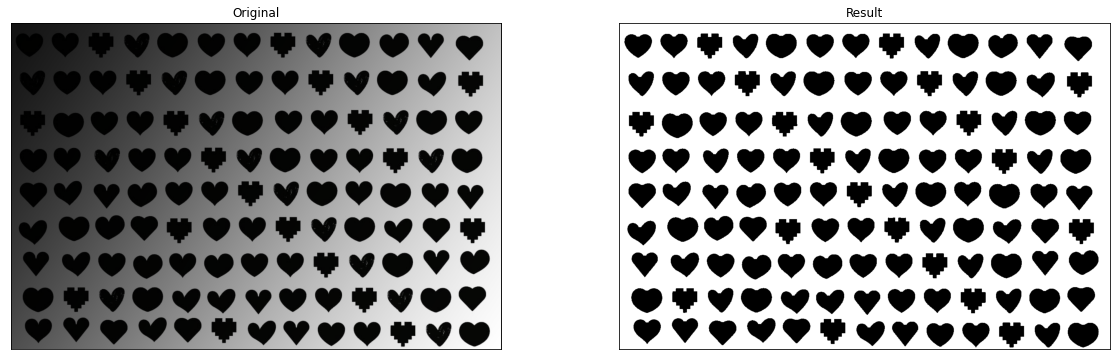

In [ ]:
img = extract(imgs[0], 'hearts_1')

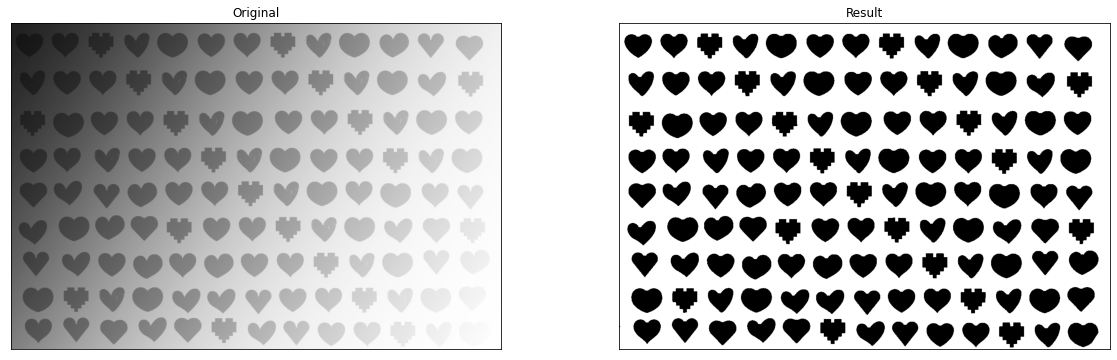

In [ ]:
img = extract(imgs[1], 'hearts_2')

## Picture #3
Steps:
- Objects in images #3 and #4 are more brighter so that we can extract objects based on H and S channels from HSV
- Then we use binary threshold
- For picture #3 we get some holes, so next steps are for filling undesirable holes
- For that we use morphological operation and then find contours and fill in the area inside

In [ ]:
# Run this step to find values for the mask
num = 2
img = imgs[num].copy()
d = {'lMin': (0, 179, 0), 'aMin': (0, 255, 0), 'bMin': (0, 255, 0), 'lMax': (0, 255, 255), 'aMax': (0, 255, 255), 'bMax': (0, 255, 255)}
def inRange(image, vals):
    lower = np.array([vals[0], vals[1], vals[2]])
    upper = np.array([vals[3], vals[4], vals[5]])
    lab = cv2.cvtColor(image, cv2.COLOR_BGR2LAB)
    mask = cv2.inRange(lab, lower, upper)
    res = cv2.bitwise_and(image, image, mask=mask)
    return res
param_selection(img, d, inRange)

lMin = 0 aMin = 0 bMin = 0 lMax = 255 aMax = 255 bMax = 255 


In [ ]:
num = 2
img = imgs[num].copy()
lab = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)
mask = cv2.inRange(lab, (102, 25, 25), (255, 194,255))
img = mask
kernel = np.ones((3,3),np.uint8)
img = cv2.erode(img,kernel,iterations =1)
img = draw_border(img, mode = 0)
img = draw_border(img, mode = 1)
cv2.imwrite('res\hearts_segmented_'+ str(num + 1) +'.png', img)
if show_result_flag:
    show_result(img)

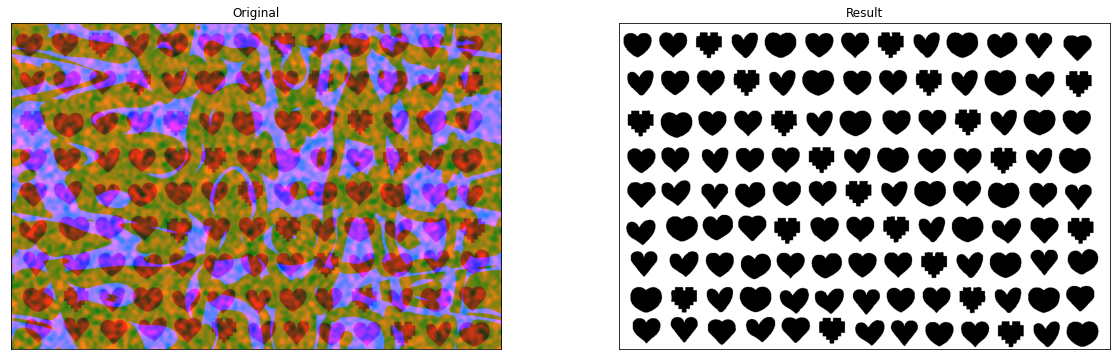

In [ ]:
plot_result(imgs[num], img)

## Picture #4
Steps are almost the same as for #3, butit was a bit easier since there were not holes
Steps:
- Extract objects based on H and S channels from HSV
- Delete some small artifacts

In [ ]:
# Only run to find range for green chanel
num = 3
img = imgs[num].copy()
d = {'hMin': (0, 179, 0), 'sMin': (0, 255, 0), 'vMin': (0, 255, 0), 'hMax': (0, 179, 179), 'sMax': (0, 255, 255), 'vMax': (0, 255, 255)}
def inRange(image, vals):
    lower = np.array([vals[0], vals[1], vals[2]])
    upper = np.array([vals[3], vals[4], vals[5]])
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    mask = cv2.inRange(hsv, lower, upper)
    res = cv2.bitwise_and(image, image, mask=mask)
    return res
param_selection(img, d, inRange)

hMin = 0 sMin = 0 vMin = 0 hMax = 179 sMax = 255 vMax = 255 


In [ ]:
num = 3
img = imgs[num].copy()
hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
mask = cv2.inRange(hsv, (36, 25, 25), (70, 255,255))
img = 255 - mask
kernel = np.ones((3,3),np.uint8)
img = cv2.erode(img,kernel,iterations =1)
img = draw_border(img, mode = 0)
img = draw_border(img, mode = 1)
cv2.imwrite('res\hearts_segmented_'+ str(num + 1) +'.png', img)
if show_result_flag:
    show_result(img)

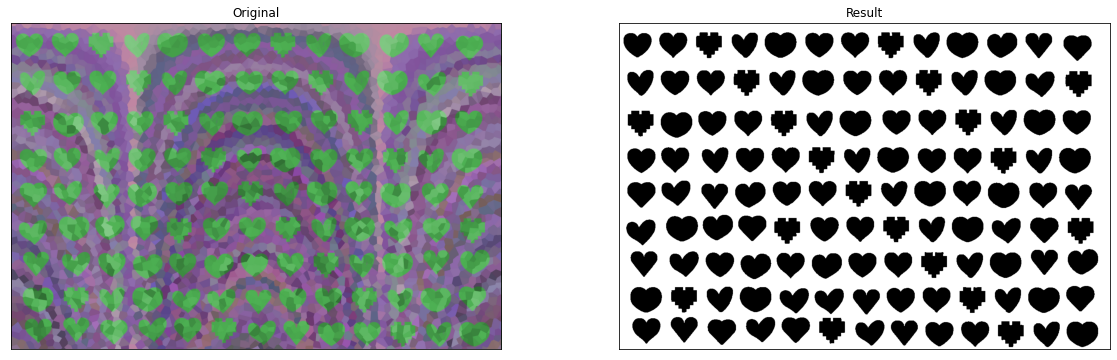

In [ ]:
plot_result(imgs[num], img)

## Picture #5
For pictures #5, #6, #7, #8 all steps are similar

Steps:
- We use morphology to smooth noise
- Use apative threshold to find objects
- Use dilate for delete small noises

In [ ]:
def extract(img, vals):
    kernel = np.ones((vals[0],vals[0]),np.uint8)
    img = cv2.dilate(img,kernel,iterations = vals[1])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img = cv2.adaptiveThreshold(img,255,cv2.ADAPTIVE_THRESH_MEAN_C,cv2.THRESH_BINARY, 2 * vals[2] + 1,vals[3])
    img = cv2.dilate(img,kernel,iterations = 1)
    return img

In [ ]:
# Only run to find parameters
num = 4
img = imgs[num].copy()
d = {'Kernel_size':(1, 10, 3),'Iteration':(1, 10, 1), 'Thresh_half': (10, 800, 95), 'Thresh_diam': (2, 55, 2)}
def threshFunc(img, vals):
    kernel = np.ones((vals[0],vals[0]),np.uint8)
    img = cv2.dilate(img,kernel,iterations = vals[1])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img = cv2.adaptiveThreshold(img,255,cv2.ADAPTIVE_THRESH_MEAN_C,cv2.THRESH_BINARY,2 * vals[2] + 1,vals[3])
    img = cv2.dilate(img,kernel,iterations = 1)
    return img
param_selection(img, d, threshFunc)

Kernel_size = 3 Iteration = 1 Thresh_half = 95 Thresh_diam = 2 


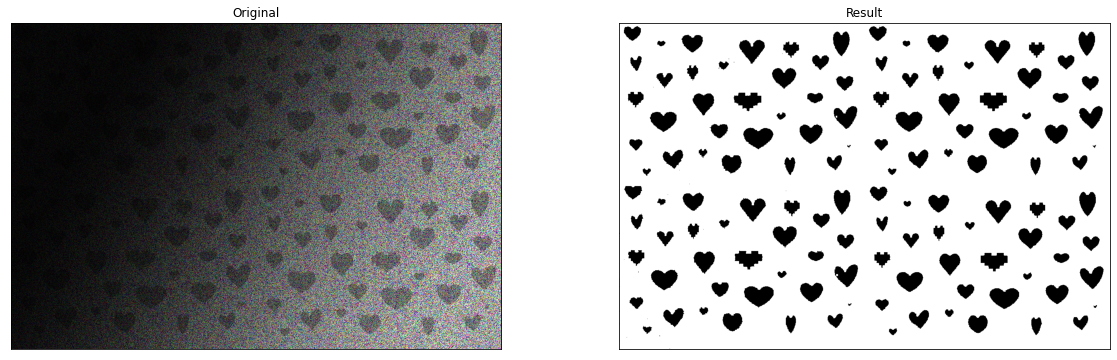

In [ ]:
num = 4
img = imgs[num].copy()
img = extract(img, [3, 1, 60, 2])
cv2.imwrite('res\hearts_segmented_'+ str(num + 1) +'.png', img)
if show_result_flag:
    show_result(img)
plot_result(imgs[num], img)

## Picture #6

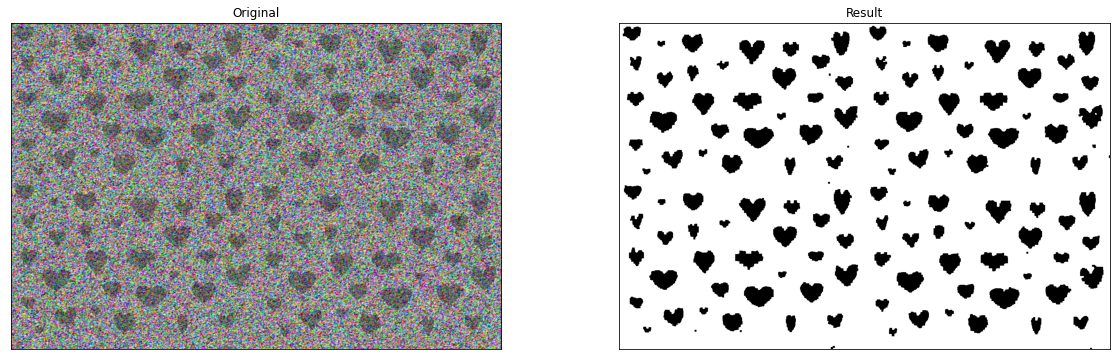

In [ ]:
num = 5
img = imgs[num].copy()
img = extract(img, [3, 1, 145, 7])
kernel = np.ones((3,3),np.uint8)
img = cv2.morphologyEx(img, cv2.MORPH_CLOSE, kernel, iterations=2)
#img = cv2.dilate(img,kernel,iterations = 1)
cv2.imwrite('res\hearts_segmented_'+ str(num + 1) +'.png', img)
if show_result_flag:
    show_result(img)
plot_result(imgs[num], img)

## Picture #7

In [ ]:
# Only run to find parameters
# Kernel_size = 3 Iteration = 1 Thresh_half = 65 Thresh_diam = 1
num = 6
img = imgs[num].copy()
d = {'Kernel_size':(1, 10, 3),'Iteration':(1, 10, 1), 'Thresh_half': (10, 800, 55), 'Thresh_diam': (2, 55, 2)}
def threshFunc(img, vals):
    kernel = np.ones((vals[0],vals[0]),np.uint8)
    img = cv2.dilate(img,kernel,iterations = vals[1])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img = cv2.adaptiveThreshold(img,255,cv2.ADAPTIVE_THRESH_MEAN_C,cv2.THRESH_BINARY,2 * vals[2] + 1,vals[3])
    #img = cv2.dilate(img,kernel,iterations = 1)
    return img
param_selection(img, d, threshFunc)

Kernel_size = 3 Iteration = 1 Thresh_half = 55 Thresh_diam = 2 


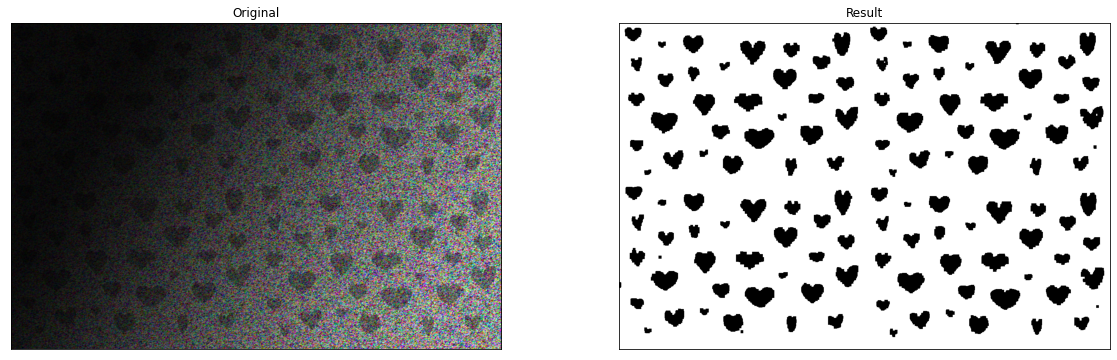

In [ ]:
num = 6
img = imgs[num].copy()
img = extract(img, [3, 1, 55, 1])
kernel = np.ones((4,4),np.uint8)
img = cv2.morphologyEx(img, cv2.MORPH_CLOSE, kernel, iterations=2)
cv2.imwrite('res\hearts_segmented_'+ str(num + 1) +'.png', img)
if show_result_flag:
    show_result(img)
plot_result(imgs[num], img)

## Picture #8
I have tried to used here different kernel such as rectangle, ellipse, cross, but then I decided to create a kernel with shape similar to the shape we are looking for.
So, steps are the same as for previous 3 pictures but kernel is different

(7, 7)


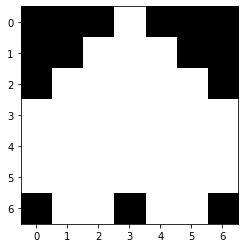

In [ ]:
kernel = np.array([[0, 0, 0, 1, 0, 0, 0],
                   [0, 0, 1, 1, 1, 0, 0],
                   [0, 1, 1, 1, 1, 1, 0],
                   [1, 1, 1, 1, 1, 1, 1],
                   [1, 1, 1, 1, 1, 1, 1],
                   [1, 1, 1, 1, 1, 1, 1],
                   [0, 1, 1, 0, 1, 1, 0]
                   ], np.uint8)
print(kernel.shape)
plt.imshow(kernel, cmap='gray')

(14, 15)


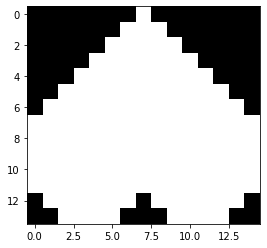

In [23]:
kernel = np.array([[0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
                   [0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0],
                   [0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0],
                   [0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0],
                   [0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0],
                   [0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0],
                   [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0],
                   [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
                   [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
                   [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
                   [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
                   [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
                   [0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0],
                   [0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0],
                   #[0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0],
                   #[0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0],
                   ], np.uint8)
print(kernel.shape)
plt.imshow(kernel, cmap='gray')

(13, 13)
Iteration = 1 Thresh_half = 95 Thresh_diam = 2 
Iteration = 1 Thresh_half = 94 Thresh_diam = 2 
Iteration = 1 Thresh_half = 92 Thresh_diam = 2 
Iteration = 1 Thresh_half = 90 Thresh_diam = 2 
Iteration = 1 Thresh_half = 86 Thresh_diam = 2 
Iteration = 1 Thresh_half = 80 Thresh_diam = 2 
Iteration = 1 Thresh_half = 78 Thresh_diam = 2 
Iteration = 1 Thresh_half = 77 Thresh_diam = 2 
Iteration = 1 Thresh_half = 72 Thresh_diam = 2 
Iteration = 1 Thresh_half = 71 Thresh_diam = 2 
Iteration = 1 Thresh_half = 69 Thresh_diam = 2 
Iteration = 1 Thresh_half = 68 Thresh_diam = 2 
Iteration = 1 Thresh_half = 66 Thresh_diam = 2 
Iteration = 1 Thresh_half = 64 Thresh_diam = 2 
Iteration = 1 Thresh_half = 62 Thresh_diam = 2 
Iteration = 1 Thresh_half = 61 Thresh_diam = 2 
Iteration = 1 Thresh_half = 58 Thresh_diam = 2 
Iteration = 1 Thresh_half = 55 Thresh_diam = 2 
Iteration = 1 Thresh_half = 58 Thresh_diam = 2 
Iteration = 1 Thresh_half = 65 Thresh_diam = 2 
Iteration = 1 Thresh_half = 69 

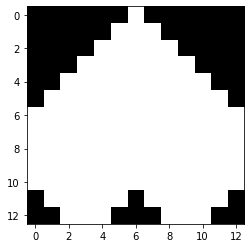

In [6]:
# Only run to find parameters
# Kernel_size = 3 Iteration = 2 Thresh_half = 69 Thresh_diam = 2 
# 13 x 13, 2, 59, 4
num = 7
img = imgs[num].copy()
d = {'Iteration':(1, 10, 1), 'Thresh_half': (10, 800, 95), 'Thresh_diam': (2, 55, 2)}
kernel = np.array([[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
                   [0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0],
                   [0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0],
                   [0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0],
                   [0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0],
                   [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0],
                   [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
                   [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
                   [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
                   [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
                   [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
                   [0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0],
                   [0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0]
                   ], np.uint8)
print(kernel.shape)
plt.imshow(kernel, cmap='gray')
def threshFunc(img, vals):
    img = cv2.morphologyEx(img, cv2.MORPH_CLOSE, kernel, iterations=vals[0])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img = cv2.adaptiveThreshold(img,255,cv2.ADAPTIVE_THRESH_MEAN_C,cv2.THRESH_BINARY,2 * vals[1] + 1,vals[2])
    #ret2,img = cv2.threshold(img,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    #img = cv2.adaptiveThreshold(img,255,cv2.ADAPTIVE_THRESH_MEAN_C,cv2.THRESH_TOZERO,2 * vals[1] + 1,vals[2])
    #img = cv2.multiply(img, th)
    return img
param_selection(img, d, threshFunc)

True

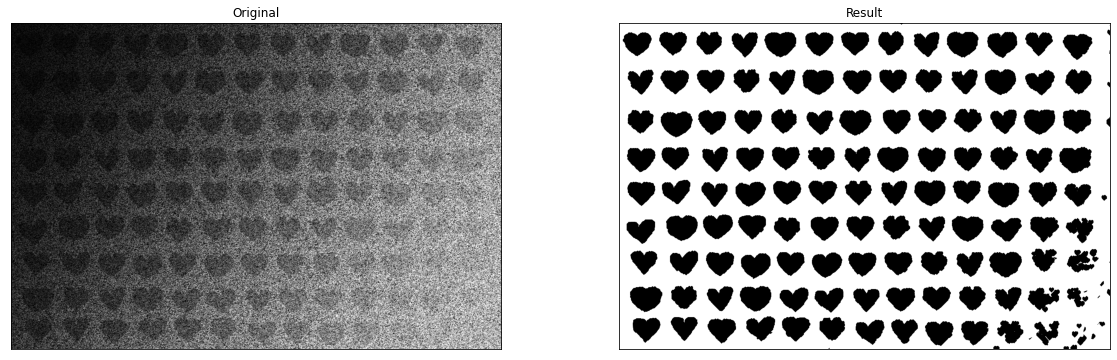

In [7]:
num = 7
img = imgs[num].copy()
kernel = np.array([[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
                   [0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0],
                   [0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0],
                   [0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0],
                   [0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0],
                   [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0],
                   [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
                   [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
                   [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
                   [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
                   [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
                   [0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0],
                   [0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0]
                   ], np.uint8)
img = cv2.morphologyEx(img, cv2.MORPH_CLOSE, kernel, iterations=1)
img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
img = cv2.adaptiveThreshold(img,255,cv2.ADAPTIVE_THRESH_MEAN_C,cv2.THRESH_BINARY,2 * 68 + 1,6)
show_result(img)
plot_result(imgs[num], img)
cv2.imwrite('res\hearts_segmented_'+ str(num + 1) +'.png', img)

## Picture #9
Here we built a histogram and we can see that our pixels are respresented mostly by 2 values so we may use a global threshold with value equal to 253-254 or we can just use thresholding with OTSU

(array([2128545.,       0.,       0.,   47370.,       0.,       0.,
          55485.,       0.,       0., 1036440.]),
 array([252. , 252.3, 252.6, 252.9, 253.2, 253.5, 253.8, 254.1, 254.4,
        254.7, 255. ]),
 <BarContainer object of 10 artists>)

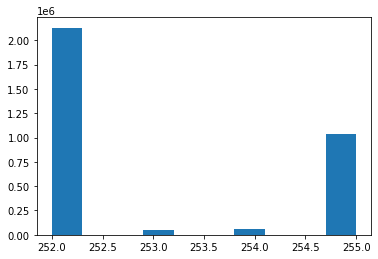

In [26]:
num = 8
img = imgs[num].copy()
plt.hist(img.ravel())

True

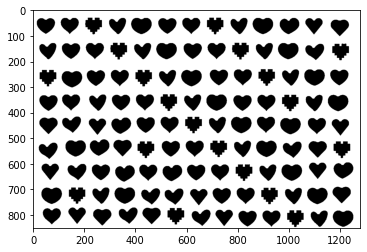

In [27]:
num = 8
img = imgs[num].copy()
img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
_, img = cv2.threshold(img,0,255,cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)
img = delete_small_artifacts(img)
img = draw_border(img, mode = 0)
if show_result_flag:
    show_result(img)
plt.imshow(img, cmap='gray')
cv2.imwrite('res\hearts_segmented_heart_'+ str(num + 1) +'.png', img)

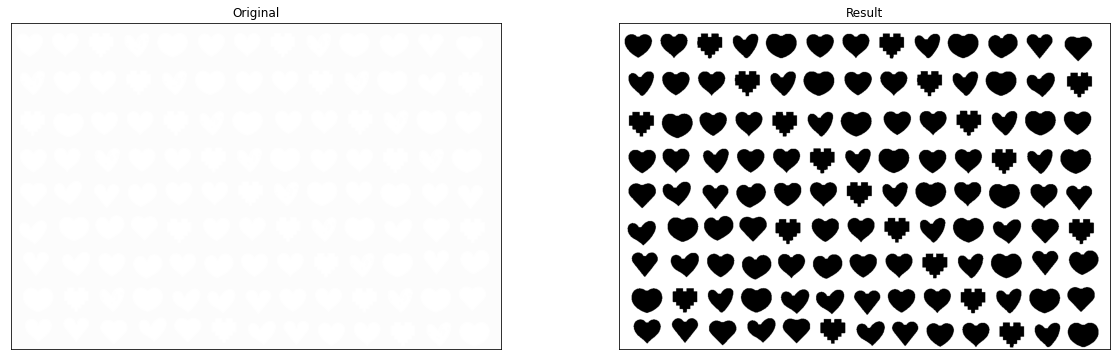

In [28]:
plot_result(imgs[num], img)

## Picture #10
Steps:
- Use Canny filter to find borders
- Some borders have holes so use dilate to fill out them
- Find external contours and fill the in

In [29]:
num = 9
img = imgs[num].copy()
d = {'t_lower': (0, 1000, 0), 't_upper': (0, 1000, 200)}
def canny(img, vals):
    res = cv2.Canny(img,vals[0],vals[1])
    return res
param_selection(img, d, canny)

t_lower = 0 t_upper = 200 


In [30]:
imgs_steps = []; names = [] # for snapshots

Count of objects 117


True

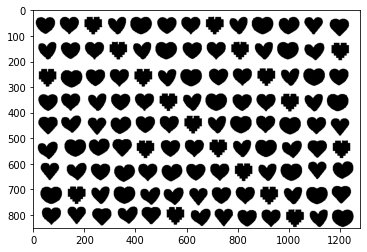

In [31]:
num = 9
img = imgs[num].copy()
imgs_steps.append(img.copy()); names.append("Original") # save snapshot
img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
img = cv2.Canny(img,150,300, 5)
imgs_steps.append(img.copy()); names.append("Canny") # save snapshot
kernel = np.ones((4,4),np.uint8)
img = cv2.dilate(img,kernel,iterations = 1)
imgs_steps.append(img.copy()); names.append("Dilate") # save snapshot
img = fill_contours(img, upper_area_thresh = 100, color = (255, 255, 255), external = True)
imgs_steps.append(img.copy()); names.append("Fill contours") # save snapshot
img = 255 - img
imgs_steps.append(img.copy()); names.append("Invert result") # save snapshot
img = draw_border(img, mode = 0)
img = draw_border(img, mode = 1)
img = draw_border(img, mode = 3)
imgs_steps.append(img.copy()); names.append("Result") # save snapshot
show_result(img)
plt.imshow(img, cmap='gray')
cv2.imwrite('res\hearts_segmented_heart_'+ str(num + 1) +'.png', img)

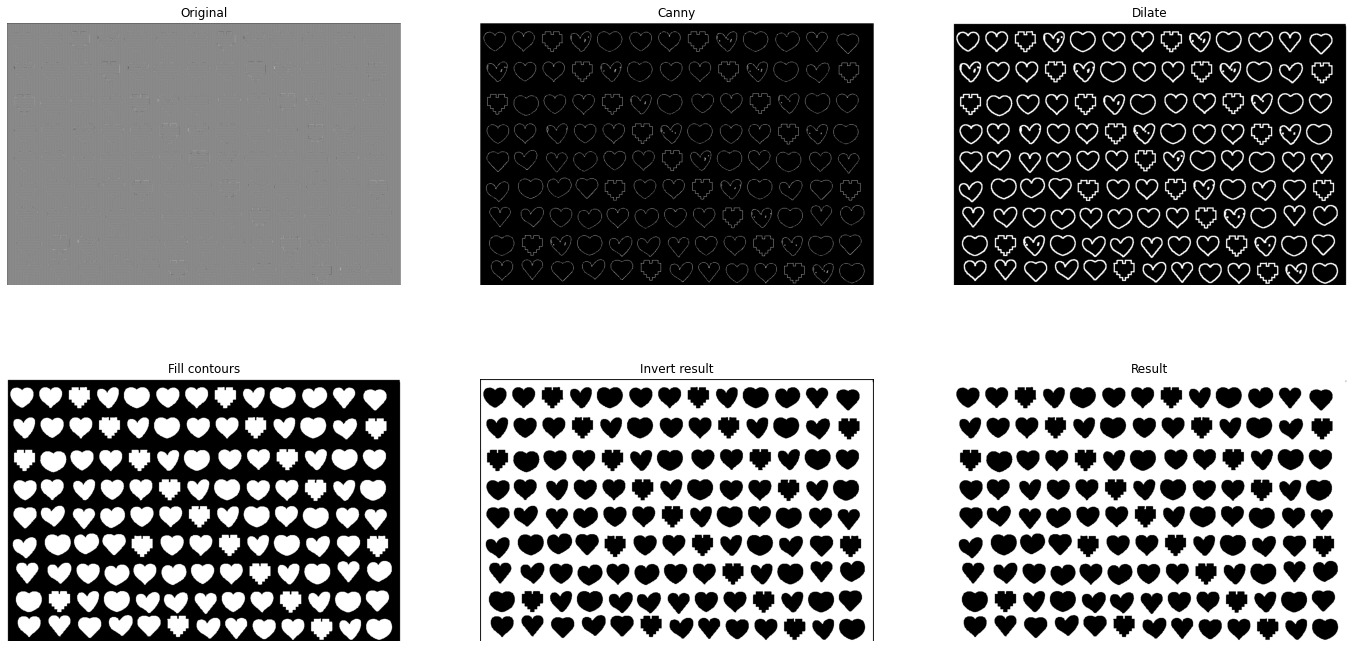

In [32]:
plot_steps(imgs_steps, names)

## Other

In [ ]:
d = {'Diameter': (0, 100, 10), 'SigmaColor': (0, 500, 50), 'SigmaSpace': (0, 500, 50)}
def bilateralFilterFunc(image, vals):
    res = cv2.bilateralFilter(image, vals[0], vals[1], vals[2])
    return res
param_selection(img, d, bilateralFilterFunc)

d = {'sigmaX': (0, 100, 0), 'sigmaY': (0, 100, 0), 'steps': (1, 10, 1)}
def gaussianBlur(image, vals):
    res = image.copy()
    for i in range(vals[2]):
        res = cv2.GaussianBlur(res, (3, 3), sigmaX = vals[0], sigmaY = vals[1])
    return res
param_selection(img, d, gaussianBlur)